In [87]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D
from keras.optimizers import SGD
from numpy.random import uniform
import keras
from tensorflow.keras import layers

In [88]:
def generate_mixed_shape(shape1, shape2, shape3, shape4):
    shape = []
    shape.extend(shape1[:15].tolist())
    shape.extend(shape2[15:30].tolist())
    shape.extend(shape3[30:45].tolist())
    shape.extend(shape4[45:60].tolist())
    return pd.DataFrame([shape])

In [89]:
def generate_noisy_shape(shape):
    noisyShape = []
    for val in shape:
        noisyShape.append(val + uniform(-0.3, 0.3))
    return pd.DataFrame([noisyShape])

In [90]:
symbol_data = pd.read_csv("data/dataset1_fixed.csv", header=None)
X = symbol_data.iloc[:, :-1]
Y = symbol_data.iloc[:,-1:]
Y = Y.replace("Time", 0)
Y = Y.replace("Wind", 1)
Y = Y.replace("Fire", 2)
Y = Y.replace("Earth", 3)
Y = Y.replace("Water", 4)
Y = Y.replace("Lightning", 5)

for i in range(100):
    random_symbols = X.sample(n=4)
    X = pd.concat([X, generate_mixed_shape(random_symbols.iloc[0], random_symbols.iloc[1], random_symbols.iloc[2], random_symbols.iloc[3])])
    Y = pd.concat([Y, pd.DataFrame([6], columns =[60])])
 
for i in range(100):
    random_symbol = X.sample(n=1)
    X = pd.concat([X, pd.DataFrame(generate_noisy_shape(random_symbol.iloc[0]))])
    Y = pd.concat([Y, pd.DataFrame([6], columns =[60])])

x_train, x_test, y_train, y_test = train_test_split(np.array(X), Y, test_size=0.20)


y_test = y_test.values.flatten().astype("float64")
y_train = y_train.values.flatten().astype("float64")

In [91]:
x_train_3d = [np.array(x_train[i]).reshape(-1, 3) for i in range(len(x_train))]
x_test_3d = [np.array(x_test[i]).reshape(-1, 3) for i in range(len(x_test))]

x_train_3d = tf.stack(x_train_3d)
x_test_3d = tf.stack(x_test_3d)

In [92]:
print(x_test_3d)

tf.Tensor(
[[[4.742373e-01 8.367742e-01 7.813451e-04]
  [3.473052e-01 6.967357e-01 1.096882e-03]
  [2.274754e-01 5.635937e-01 1.273823e-03]
  ...
  [6.520981e-01 9.249974e-01 2.503306e-04]
  [8.851222e-01 8.884290e-01 9.682045e-05]
  [9.481151e-01 8.838500e-01 1.751080e-05]]

 [[2.214500e-01 8.557274e-01 0.000000e+00]
  [3.446979e-01 8.169086e-01 3.821915e-04]
  [4.435306e-01 7.472460e-01 7.752517e-04]
  ...
  [4.876755e-01 1.000000e+00 1.968734e-04]
  [4.876755e-01 1.000000e+00 1.968734e-04]
  [4.876755e-01 1.000000e+00 1.968734e-04]]

 [[2.069637e-01 5.783117e-01 6.819833e-04]
  [2.006461e-01 4.336390e-01 9.836258e-04]
  [1.753646e-01 2.930146e-01 1.155749e-03]
  ...
  [1.680775e-01 5.904664e-01 3.522003e-04]
  [0.000000e+00 5.247798e-01 2.765947e-04]
  [0.000000e+00 5.247798e-01 2.765947e-04]]

 ...

 [[0.000000e+00 0.000000e+00 5.369184e-04]
  [3.286989e-02 1.137921e-01 4.435014e-04]
  [1.021256e-01 2.176252e-01 3.813094e-04]
  ...
  [8.050801e-01 0.000000e+00 1.301448e-03]
  [8.05

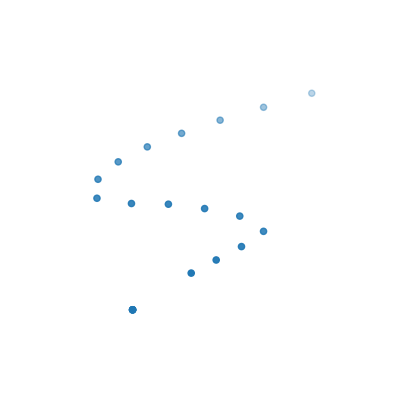

label:  5.0


In [93]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
points = x_train_3d[4]
clas = y_train[4]
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
ax.view_init(elev=90, azim=0, roll=90)
plt.show()
print("label: ", clas)

In [94]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label

In [95]:
NUM_POINTS = 20
NUM_CLASSES = 7
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_3d, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_3d, y_test))

train_dataset = train_dataset.shuffle(len(x_train_3d)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(x_test_3d)).batch(BATCH_SIZE)

In [96]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 20, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [97]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [98]:
class OrthogonalRegularizerTest(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))
    
    def get_config(self):
        return {'num_features': float(self.num_features), 'l2reg': float(self.l2reg)}

In [99]:
type(tf.eye(3))

tensorflow.python.framework.ops.EagerTensor

In [100]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizerTest(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [101]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 3)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 20, 32)       128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 20, 32)      128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 20, 32)       0           ['batch_normalization[0][0

In [102]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
20/20 [==============================] - 5s 56ms/step - loss: 3.3392 - sparse_categorical_accuracy: 0.4797 - val_loss: 4.1627 - val_sparse_categorical_accuracy: 0.6149
Epoch 2/20
20/20 [==============================] - 1s 30ms/step - loss: 2.2773 - sparse_categorical_accuracy: 0.6797 - val_loss: 12120479.0000 - val_sparse_categorical_accuracy: 0.7329
Epoch 3/20
20/20 [==============================] - 1s 30ms/step - loss: 1.8442 - sparse_categorical_accuracy: 0.8125 - val_loss: 2.1591 - val_sparse_categorical_accuracy: 0.8137
Epoch 4/20
20/20 [==============================] - 1s 30ms/step - loss: 1.7538 - sparse_categorical_accuracy: 0.8219 - val_loss: 4.2245 - val_sparse_categorical_accuracy: 0.8199
Epoch 5/20
20/20 [==============================] - 1s 30ms/step - loss: 1.8226 - sparse_categorical_accuracy: 0.8078 - val_loss: 23724.3145 - val_sparse_categorical_accuracy: 0.8261
Epoch 6/20
20/20 [==============================] - 1s 30ms/step - loss: 1.6804 - sparse_categ

1/1 [==============================] - 0s 424ms/step


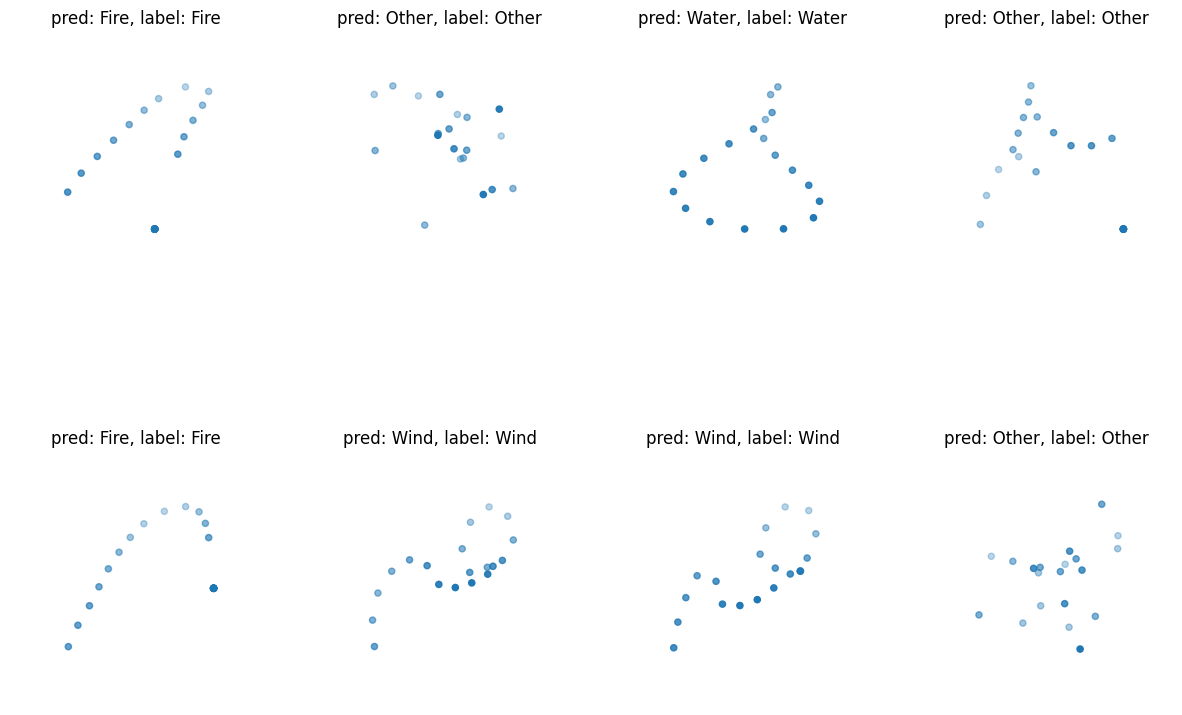

In [103]:
class_map = {}
class_map[0] = "Time"
class_map[1] = "Wind"
class_map[2] = "Fire"
class_map[3] = "Earth"
class_map[4] = "Water"
class_map[5] = "Lightning"
class_map[6] = "Other"

data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            class_map[preds[i].numpy()], class_map[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()    
    ax.view_init(elev=90, azim=0, roll=90)
plt.show()


In [104]:
model.save('model_3d_with_other')

INFO:tensorflow:Assets written to: model_3d_with_other\assets


INFO:tensorflow:Assets written to: model_3d_with_other\assets


In [105]:
model.evaluate(test_dataset)

6/6 [==============================] - 0s 6ms/step - loss: 2913210.7500 - sparse_categorical_accuracy: 0.8696


[2913210.75, 0.8695651888847351]

In [106]:
inverted_rune_data = pd.read_csv("InvertedRunes.csv", header=None)
inverted_runes_X = inverted_rune_data.iloc[:, :-1]

inverted_runes_Y = inverted_rune_data.iloc[:,-1:]
inverted_runes_Y = inverted_runes_Y.replace("Time", 0)
inverted_runes_Y = inverted_runes_Y.replace("Wind", 1)

inverted_runes_X_3d = [np.array(inverted_runes_X[i]).reshape(-1, 3) for i in range(len(inverted_runes_X))]
inverted_runes_X_3d = tf.stack(inverted_runes_X_3d)

FileNotFoundError: [Errno 2] No such file or directory: 'InvertedRunes.csv'

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
points = inverted_runes_X_3d[2]
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
ax.view_init(elev=90, azim=0, roll=90)
plt.show()

In [75]:
test_model = keras.models.load_model('model_3d_with_other')
test_model.evaluate(test_dataset)

ValueError: Unknown regularizer: OrthogonalRegularizerTest. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.